# 1. Imports and configuration

In [1]:
from pathlib import Path
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

pd.set_option("display.max_colwidth", 200)


# 2. Utility functions

In [2]:

def _normalize_token(x: Any) -> str:
    try:
        s = str(x).strip().lower()
    except Exception:
        s = ""
    return s.rstrip(".,")


# 3. Load dataset

In [3]:
file_path = Path("../Data/Raw/Uitgebreide_VKM_dataset.csv")
suffix = file_path.suffix.lower()

if suffix in {".csv", ".tsv", ".txt"}:
    sep = "\t" if suffix == ".tsv" else ","
    df = pd.read_csv(file_path, sep=sep, low_memory=False)
elif suffix in {".xlsx", ".xls"}:
    df = pd.read_excel(file_path)
elif suffix == ".json":
    try:
        df = pd.read_json(file_path, orient="records", lines=False)
    except Exception:
        df = pd.read_json(file_path, lines=True)
elif suffix == ".parquet":
    df = pd.read_parquet(file_path)
else:
    raise ValueError(f"Unsupported file type: {suffix}")

df.head()


,id,name,shortdescription,description,content,studycredit,location,contact_id,level,learningoutcomes,Rood,Groen,Blauw,Geel,module_tags,interests_match_score,popularity_score,estimated_difficulty,available_spots,start_date
0,159,Kennismaking met Psychologie,"Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen.",In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met...,In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met...,15,Den Bosch,58,NLQF5,A. Je beantwoordt vragen in een meerkeuze kennistoets waarin je laat zien dat je de basis van de psychologie kunt reproduceren en begrijpt. Je laat zien dat je gedrag van individuen en groepen in ...,4.0,2.0,1.0,5.0,"['brein', 'gedragsbeinvloeding', 'ontwikkelingspsychologie', 'gespreksvoering', 'en', 'ontwikkelingsfasen']",0.54,319,1,79,2025-12-24
1,160,Learning and working abroad,"Internationaal, persoonlijke ontwikkeling, verpleegkunde","Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsprestaties graag in een internationale stagecontext willen...","Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsprestaties graag in een internationale stagecontext willen...",15,Den Bosch,58,NLQF5,De student toont professioneel gedrag conform de beroepscode bij laagcomplexe zorgvragers en collega's in de zorgsetting.,5.0,3.0,1.0,1.0,"['internationaal', 'persoonlijke', 'ontwikkeling', 'verpleegkunde']",0.92,172,5,56,2025-12-20
2,161,Proactieve zorgplanning,"Proactieve zorgplanning, cocreatie, ziekenhuis","Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zich te verdiepen in de ziekenhuissetting. JBZ sta...","Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zich te verdiepen in de ziekenhuissetting. JBZ sta...",15,Den Bosch,59,NLQF5,"De student past pro actieve zorgplanning toe binnen het proces van het klinisch redeneren bij casuïstiek over zorgvragers, multidisciplinair, in de ziekenhuissetting.",NaN,NaN,NaN,NaN,"['proactieve', 'zorgplanning', 'cocreatie', 'ziekenhuis']",0.78,217,5,55,2025-09-23
3,162,Rouw en verlies,"Rouw & verlies, palliatieve zorg & redeneren, trauma, culturele diversiteit","In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema's zoals oncologie kunnen hier een plaats krijgen (werkveld verpleegkunde vra...","In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema's zoals oncologie kunnen hier een plaats krijgen (werkveld verpleegkunde vra...",30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfstandig en in samenwerkingsverband het palliatieve proces uit bij hoog/middencomplexe zorgvragers in de zorgsetting op basis van het proces van palliatie...,NaN,NaN,NaN,NaN,"['rouw', 'verlies', 'palliatieve', 'zorg', 'redeneren', 'trauma', 'culturele', 'diversiteit']",0.69,454,1,54,2025-10-25
4,163,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie","In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied.","In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied.",30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfstandig en in samenwerkingsverband het verpleegkundige proces uit bij hoog/middencomplexe zorgvragers in de actue en

# 4. Inspect dataset

In [4]:
# Quick dataset inspection (to run in a new notebook cell)
print("Shape:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)

print("\nFirst 5 rows:")
print(df.head())

# Missingness summary (use existing 'miss' if present)
if 'miss' in globals():
    print("\nMissing % (existing variable 'miss'):")
    print(miss.sort_values(ascending=False))
else:
    miss_local = df.isnull().mean() * 100
    print("\nMissing %:")
    print(miss_local.sort_values(ascending=False))

# Numeric summary (use existing 'num' if present)
if 'num' in globals() and not num.empty:
    print("\nNumeric summary (existing variable 'num'):")
    print(num.describe().T)
else:
    num_local = df.select_dtypes(include=[np.number])
    print("\nNumeric summary:")
    print(num_local.describe().T)

# Categorical columns and top values (avoid overwriting existing 'cat_cols' if present)
if 'cat_cols' in globals():
    cats = [col for col in cat_cols if col in df.columns]
else:
    cats = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nCategorical columns to inspect:", cats)
for col in cats:
    print(f"\n--- {col} ---")
    try:
        vc = df[col].value_counts(dropna=False).head(10)
        print("Top values:\n", vc)
        print("Unique (non-null):", df[col].nunique(dropna=True))
    except Exception as e:
        print("Could not compute value_counts:", e)

# Parse and summarize start_date (safely)
if 'start_date' in df.columns:
    dates = pd.to_datetime(df['start_date'], errors='coerce')
    print("\nstart_date parsing:")
    print("Nulls after parsing:", dates.isna().sum())
    print("Top parsed dates:")
    print(dates.value_counts().head())

text_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Memory usage
print("\nMemory usage (MB):", df.memory_usage(deep=True).sum() / 1024**2)

Shape: (211, 20)

Columns and dtypes:
id                         int64
name                      object
shortdescription          object
description               object
content                   object
studycredit                int64
location                  object
contact_id                 int64
level                     object
learningoutcomes          object
Rood                     float64
Groen                    float64
Blauw                    float64
Geel                     float64
module_tags               object
interests_match_score    float64
popularity_score           int64
estimated_difficulty       int64
available_spots            int64
start_date                object
dtype: object

First 5 rows:
    id                          name  \
0  159  Kennismaking met Psychologie   
1  160   Learning and working abroad   
2  161       Proactieve zorgplanning   
3  162               Rouw en verlies   
4  163           Acuut complexe zorg   

                                

# 5. Numeric histograms


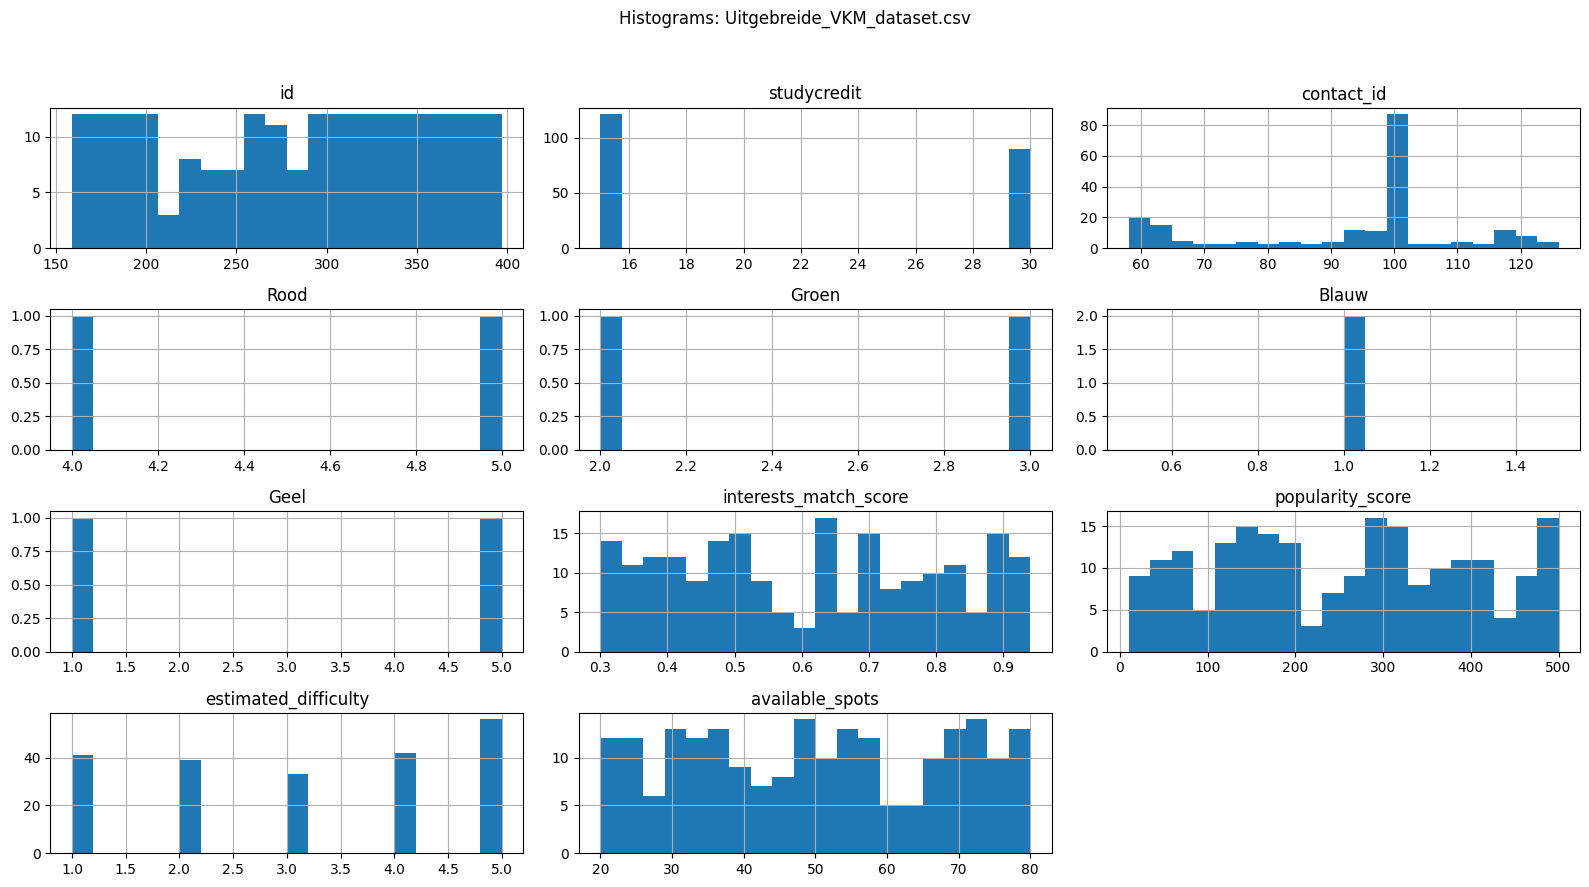

In [5]:
if not num_local.empty:
    max_cols = 100
    plot_cols = num_local.columns[:max_cols]
    nrows = math.ceil(len(plot_cols) / 4)
    figsize = (min(16, 4*len(plot_cols)), 3*nrows)
    num_local[plot_cols].hist(bins=20, figsize=figsize)
    plt.suptitle(f"Histograms: {file_path.name}")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()
